## General purpouse analysis functions

In [27]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import os
from numpy.polynomial import Polynomial
from scipy.signal import butter, filtfilt

############################################ Functions ############################################

def csv2array(file_name, folder_name, column_x_index, column_y_index, starting_row, Delimiter):
    """
    Read a CSV file stored on a subfolder and extract data from two columns.

    @param file_name: The name for the CSV file.
    @param column_x_index: The index of the first column to extract, A=0, B=1....
    @param column_y_index: The index of the second column to extract.
    @param starting_row: The row index to start reading data from, row=1, 2...
    @param Delimiter: Separator between columns

    @return: A list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @note:Expected folder structure

    folder/
    ├── notebook.ipynb
    └── subfolder/
        ├── file1.csv
        ├── file2.csv
        └── file3.csv


    @Warning: If you copy the string from Windows file browser and dont want to change backslash for '/' read it as raw by writing an 'r' before the string path like so: 'csv2array(r"C:...'



    """
    
    # Arrays to store x and y values, in that order
    column_x_values = []
    column_y_values = []

    # Fix row indexing
    starting_row = starting_row - 1

    # Dynamicaly read the path to the file
    #folder_path = os.path.dirname(os.path.abspath("Analisis_Figuras_Paper.ipynb"))
    folder_path = os.getcwd()
    CSV_PATH = os.path.join(folder_path, folder_name, file_name)


    # Read the CSV file. 'with' statement handles closing the file correctly without using 'close'.
    with open(CSV_PATH, 'r') as file:
        reader = csv.reader(file, delimiter = Delimiter)
        
        # Skip rows until the starting row
        for _ in range(starting_row):

            # next runs through an iterable
            next(reader)
        
        # Read rows until an empty cell is encountered
        for row in reader:
            if not row[column_x_index] or not row[column_y_index]:
                break  # Stop reading if either column has an empty cell
            
            # Values are read as strings, change commas for dots before casting to floats
            value_x = row[column_x_index].replace(',', '.')
            value_y = row[column_y_index].replace(',', '.')

            # Cast to floats
            column_x_values.append(float(value_x))
            column_y_values.append(float(value_y))

    # Also return a string containing the name of the data
    file_name = os.path.basename(CSV_PATH)
    file_name = os.path.splitext(file_name)[0]

    
    # Return the lists as arrays
    return [np.array(column_x_values), np.array(column_y_values), file_name]



def filter_data(order, cutoff_freq, data, Btype='low', graph=True):
    """
    Read a 2D array, design a butterworth filter, apply it and visualize it.

    This function is meant to be used in succession to csv2array, it applies a filter without delay and graphs the raw signals spectrum as well as the filtered one.
    This is done to aid in the design of the filter.

    @param order: order of the filter, since the filter is applied twice to achieve zero phase shift this is actualy half of the final order.
    @param cutoff_freq: cutoff frequency in Hz for the filter
    @param data: a list containing 2 arrays like so: [x, y]
    @param Btype: Type of filter for scipy's butter function
    @param graph: Boolean to decide wether to graph the results or not

    @return: a list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @Warning: Samples should be evenly spaced in time.
    """

    x_raw = data[0]
    y_raw = data[1]


    ################# Design Filter #########################################################################
    # Sampling frequency in Hz
    sampling_freq = 1 / (x_raw[1] - x_raw[0])

    # Convert cutoff frequency to a normalized value
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Design a Butterworth filter
    b, a = butter(order, normalized_cutoff, btype=Btype, analog=False, output='ba')

    # Apply the filter using filtfilt to achieve zero-phase filtering
    y_filt = filtfilt(b, a, y_raw)


    ################# FFT #################################################################################
    # Compute the FFT of both the raw and filtered signals
    y_fft_raw = np.fft.fft(y_raw)
    y_fft_filt = np.fft.fft(y_filt)

    # Compute frequency array, same length and with sampling interval d=Delta x
    freq = np.fft.fftfreq(len(y_raw), d=(x_raw[1] - x_raw[0]))

    # Find the indices corresponding to the desired frequency range (0 to 1.0)
    freq_indices = np.where(np.logical_and(freq >= 0, freq <= 1000))



    ################# Plot ################################################################################
    # Clear the existing subplot and plot the FFT
    if (graph):
        # Create a figure with two subplots
        fig, axs = plt.subplots(2, 1)
        ax = axs[0]
        ax.clear()
        ax.plot(freq[freq_indices], np.abs(y_fft_raw[freq_indices]), linewidth=0.5, alpha=0.25, color="black")
        ax.plot(freq[freq_indices], np.abs(y_fft_filt[freq_indices]), linewidth=0.5, color="blue")
        ax.set_ylabel('Amplitude')
        ax.set_title('FFT of '+str(data[2]))
        ax.set_xlabel('Frequency [Hz]')

        # Plot raw vs filtered data
        ax = axs[1]
        ax.scatter(x_raw, y_raw, s=1, alpha=1, color="k")
        ax.plot(x_raw, y_filt, color="blue", linewidth=1)

        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.6)

        plt.show()

    return [x_raw, y_filt, data[2]]


### Read Origin txt data

In [29]:
num_header_lines = 3  # Set the number of header lines to skip

# Open the file for reading
with open('Test7_02.txt', 'r') as file:
    # Skip the header lines
    for _ in range(num_header_lines):
        next(file)
    
    # Now, you can read and process the data
    for line in file:
        # Process each line of data as needed
        print(line.strip())  # Print the line after stripping newline characters


FileNotFoundError: [Errno 2] No such file or directory: 'Test7_02.txt'

### Read CSV data

In [30]:
BICPDMS000ROI = csv2array(file_name="BICPDMS000ROI.csv", folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')
BicStrycSf501 = csv2array(file_name="BicStrycSf501.csv", folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')

# Append to each list of data their corresponding units
BicStrycSf501.append(r'$\mu_{0} H$ [nT]')
BICPDMS000ROI.append(r'$Ca^{2+}$ [a.u.]')

# Store into one array for iterations
Data = [(BicStrycSf501), (BICPDMS000ROI)]


## Filter Data

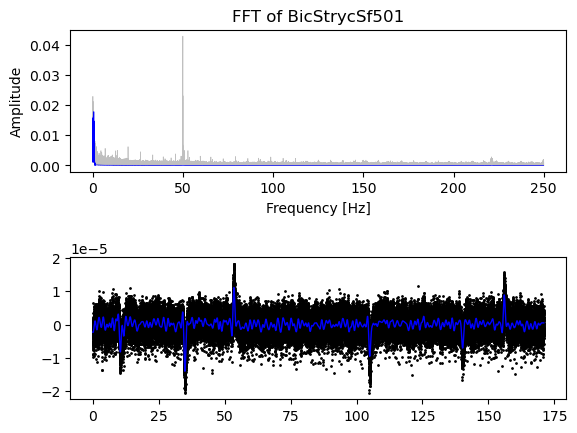

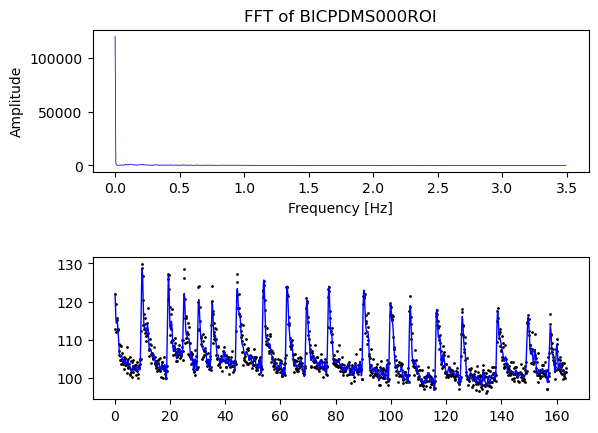

In [31]:
for data in Data:
    filter_data(order=7, cutoff_freq=1, data=data, Btype='low', graph=True)

### Bandpass example

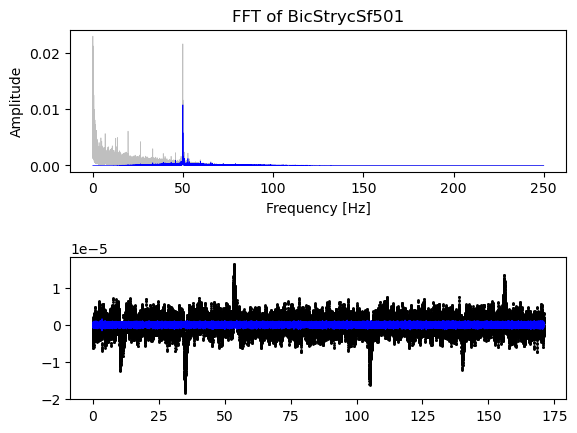

In [32]:
# Make first iteration "non-verbose"
data_LP_filt = filter_data(order=2, cutoff_freq=50, data=Data[0], Btype='low', graph=False)
data_BP_filt = filter_data(order=2, cutoff_freq=50, data=data_LP_filt, Btype='high')

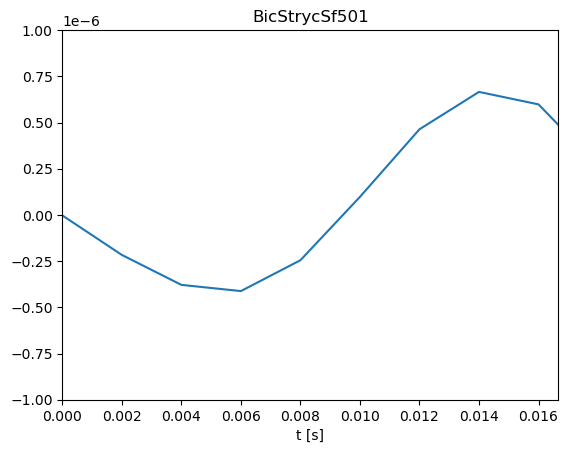

In [33]:
# Create a new figure
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Plot the data
ax.plot(data_BP_filt[0], data_BP_filt[1])

# Customize the plot
ax.set_xlabel('t [s]')
#ax.set_ylabel('')
ax.set_title(data_BP_filt[2])
ax.set_xlim(0, 1/60)
ax.set_ylim(-1E-6, 1E-6)

# Display the figure
plt.show()

### Analysis of Photodiode response curves + Transmitance

#### Extract data

In [121]:
# Get data from photodiodes spectral responsivity
Blue = csv2array(file_name='Spectral_Response.csv', folder_name="Data", column_x_index=0, column_y_index=1, starting_row=3, Delimiter=';')
Green = csv2array(file_name='Spectral_Response.csv', folder_name="Data", column_x_index=3, column_y_index=4, starting_row=3, Delimiter=';')
Red = csv2array(file_name='Spectral_Response.csv', folder_name="Data", column_x_index=6, column_y_index=7, starting_row=3, Delimiter=';')

# Convert wavelengths from m to nm
Blue[0] = 1E9 * Blue[0]
Green[0] = 1E9 * Green[0]
Red[0] = 1E9 * Red[0]

# Get data from LED relative emission
Source_Rel_Em = csv2array(file_name='LED_Relative_Emission.csv', folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')

# Store data for all transmittance curves in an array
# Initialize an empty structured array where each element can store two arrays corresponding to wavelength and transmittance. It also stores info related to said experiment
data_type = [('wavelength', object), ('transmittance', object), ('info', float)]

# Initialize an empty structured array
Transmittance = np.array([], dtype=data_type)

# Iteratively read all 9 transmittance curves from CSV and append them to the Transmitance array
for i in range(9):
    # Read transmittance curve i and wavelength
    transmittance_buff = csv2array(file_name='Transmittance.csv', folder_name="Data", column_x_index=10, column_y_index=i, starting_row=3, Delimiter=';')
    info = float(2 * i)  # Stores the minute at which the measurement was taken 

    # Append the pair of arrays to the structured array
    Transmittance = np.append(Transmittance, np.array([(transmittance_buff[0], transmittance_buff[1], info)], dtype=data_type))

### Obtain theoretical response of photodiodes

In [123]:
print(len(Source_Rel_Em[0]))
print(len(Source_Rel_Em[1]))

127
127


In [130]:
################################################## Analysis ##################################################

# Store in an array to iterate
Responsivities = np.array([Red, Green, Blue])
Traces = [[], [], []]
Spectras_at_PD = np.array([], dtype=data_type)
hack = True

for j in range(len(Responsivities)):

    wavelengths1 = Responsivities[j][0]  # Wavelengths for spectral responsivity for the photodiode
    spectral_responsivity = Responsivities[j][1]  # Spectral Responsivity A/W for the photodiode

    iterations = len(Transmittance)

    for n in range(iterations):
        wavelengths0 = Source_Rel_Em[0]
        source_aligned = Source_Rel_Em[1]

        wavelengths2 = Transmittance['wavelength'][n]  # Wavelengths in nanometers for the transmittance
        transmittance_aligned = Transmittance['transmittance'][n]  # Transmitance of the medium

        # Generate an array of wavelengths encasing all 3 curves
        common_wavelengths = np.linspace(min(min(wavelengths0), min(wavelengths1), min(wavelengths2)), max(max(wavelengths0), max(wavelengths1), max(wavelengths2)), 100)

        # Since sampled data is missaligned generate new data by interpolation at the common wavelengths
        source_aligned = np.interp(common_wavelengths, wavelengths0, source_aligned)
        transmittance_aligned = np.interp(common_wavelengths, wavelengths2, transmittance_aligned)
        responsivity_aligned = np.interp(common_wavelengths, wavelengths1, spectral_responsivity)

        # Find the response of the photodiode to the light source with wavelength dependency
        spectra_at_PD = source_aligned * transmittance_aligned 
        current_output = spectra_at_PD * responsivity_aligned

        # Integrate the result with respect to wavelength wavelength using the trapezoidal rule to find the final contribution
        PD_response = np.trapz(current_output, common_wavelengths)

        # Finaly store all calculated data to plot later on
        Traces[j].append(PD_response)
        Transmittance['wavelength'][n] = common_wavelengths
        Transmittance['transmittance'][n] = transmittance_aligned
        Source_Rel_Em[0] = common_wavelengths
        Source_Rel_Em[1] = source_aligned

        # Only store on the first run, subsequents run redo this calculation again
        if(hack):
            Spectras_at_PD = np.append(Spectras_at_PD, np.array([(common_wavelengths, spectra_at_PD, info)], dtype=data_type))

    Responsivities[j][0] = common_wavelengths
    Responsivities[j][1] = responsivity_aligned

    hack = False


# Generate time array
time = []
for m in range(9):
    time.append(m*2)


# "Pinch" data
for h in range(len(Traces)):
    Traces[h] = Traces[h] / Traces[h][0]



C:\Users\Usuario\AppData\Local\Temp\ipykernel_4772\3176420068.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Responsivities = np.array([Red, Green, Blue])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


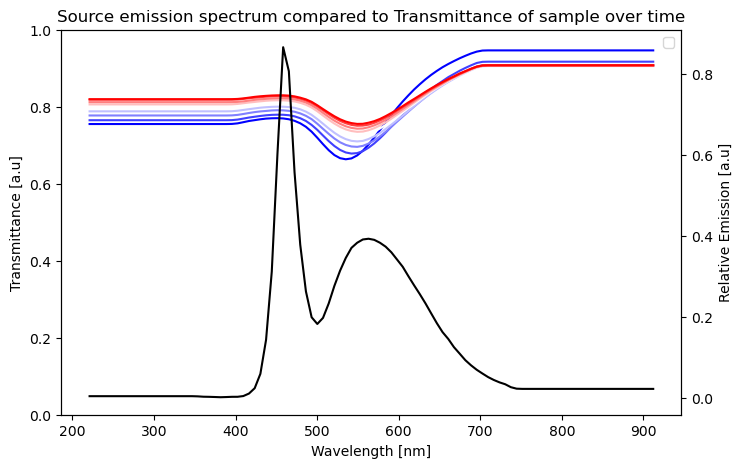

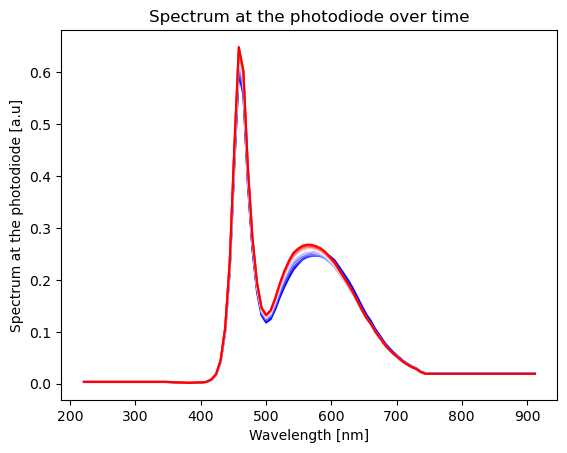

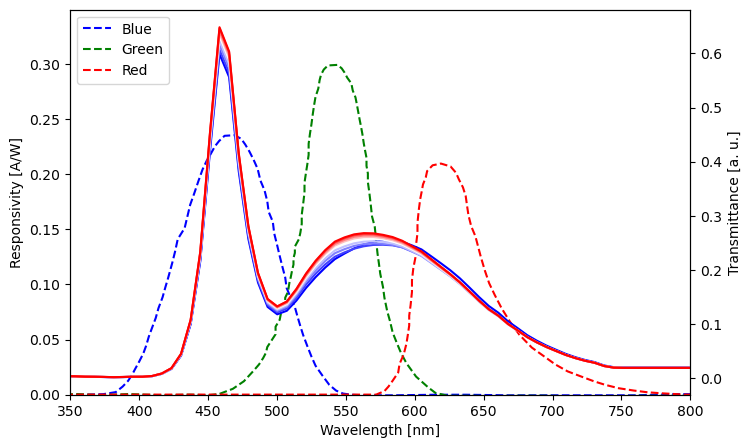

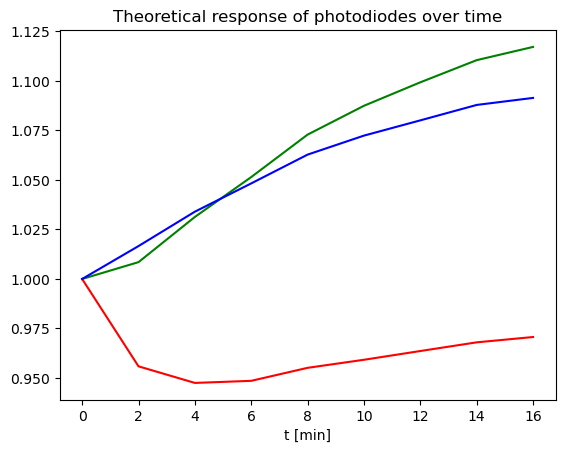

In [149]:
colors = plt.cm.bwr(np.linspace(0, 1, len(Transmittance)))  # Choose a colormap (viridis in this case)

######################################################## Figure 1 ########################################################
# Shows both the spectra of the source and the transmittance of the sample
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# Plot your additional data on the new figure (ax3)
iterations = len(Transmittance)
for n in range(iterations):
    ax2.plot(Transmittance['wavelength'][n], Transmittance['transmittance'][n], color = colors[n])
ax2.plot(Source_Rel_Em[0], Source_Rel_Em[1], color='black')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Transmittance [a.u]')
ax2.set_ylabel('Relative Emission [a.u]')
ax1.set_title('Source emission spectrum compared to Transmittance of sample over time')
ax1.legend()

######################################################## Figure 2 ########################################################
# Figure showing light spectra at photodiode
fig2 = plt.figure()

# Add a subplot
ax3 = fig2.add_subplot(111)

# Plot the data
for n in range(len(Spectras_at_PD)):
    ax3.plot(Spectras_at_PD['wavelength'][n], Spectras_at_PD['transmittance'][n], color = colors[n])

# Customize the plot
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('Spectrum at the photodiode [a.u]')
#ax.set_ylabel('')
ax3.set_title('Spectrum at the photodiode over time')

######################################################## Figure 3 ########################################################
# Create the original twin figure
fig3, ax4 = plt.subplots(figsize=(8, 5))
ax5 = ax4.twinx()

# Plot data on the original twin figure (as in your provided code)
ax4.plot(Blue[0], Blue[1], color='blue', label='Blue', linestyle='dashed')
ax4.plot(Green[0], Green[1], color='green', label='Green', linestyle='dashed')
ax4.plot(Red[0], Red[1], color='red', label='Red',linestyle='dashed')

iterations = len(Transmittance)
for n in range(iterations):
    ax5.plot(Spectras_at_PD['wavelength'][n], Spectras_at_PD['transmittance'][n], color = colors[n])

ax4.set_xlabel('Wavelength [nm]')
ax4.set_ylabel('Responsivity [A/W]')
ax5.set_ylabel('Transmittance [a. u.]')
ax4.set_ylim(0, 0.05 + max(Green[1]))
#ax2.set_ylim(0.4, 0.9)
ax4.set_xlim(350, 800)
ax4.legend(loc='upper left')

######################################################## Figure 4 ########################################################
# Final figure with evolution of traces over time
fig4 = plt.figure()

# Add a subplot
ax6 = fig4.add_subplot(111)

# Plot the data
ax6.plot(time, Traces[0], color='red')
ax6.plot(time, Traces[1], color='green')
ax6.plot(time, Traces[2], color='blue')

# Customize the plot
ax6.set_xlabel('t [min]')
#ax.set_ylabel('')
ax6.set_title('Theoretical response of photodiodes over time')

# Display the fiugres
plt.show()
